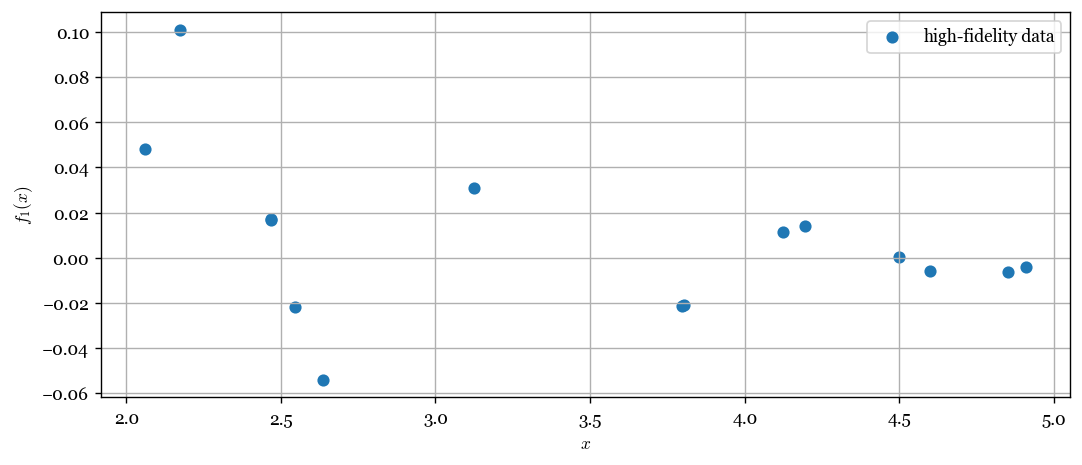

In [1]:
from speedymf import *
import math 
import matplotlib.pyplot as plt 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Seeding for repeatability 
np.random.seed(42)

# Define number of fidelity-levels 
n_fidelities = 3 

# Define a list of sample sizes
sample_sizes = [15, 50, 100]

# Define the high and low-fidelity functions
funcs = [
    lambda x: np.exp(-x) * np.sin(2*math.pi*x), 
    lambda x: np.sin(2*math.pi*x),
    lambda x: np.exp(-x)
]

# Making some testing data 
Xtest = np.linspace(0.0, 5.0, 250).reshape(-1,1)

# Loading high-fidelity data
true_data = np.hstack((Xtest, funcs[0](Xtest)))

# Selecting optimal high-fidelity data
np.random.seed(42)
cutoff = 2.0
X_hf = np.random.uniform(cutoff, 5.0, size = sample_sizes[0]).reshape(-1,1)
hf_data = np.hstack((X_hf, funcs[0](X_hf)))

# Loading medium-fidelity data 
np.random.seed(42)
X_mf = jnp.vstack((X_hf, np.random.uniform(0.0, 5.0, size = sample_sizes[1]).reshape(-1,1)))
mf_data = np.hstack((X_mf, funcs[1](X_mf)))

# Loading low-fidelity data 
np.random.seed(42)
X_lf = jnp.vstack((X_hf, np.random.uniform(0.0, 5.0, size = sample_sizes[2]).reshape(-1,1)))
lf_data = np.hstack((X_lf, funcs[2](X_lf)))

# Creating a multi-fidelity-friendly data dictionary 
data_dict = {
    2:{
        'X':hf_data[:,0].reshape(-1,1),
        'Y':hf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(hf_data[:,1]),
        'cost':1.0
    },
    1:{
        'X':mf_data[:,0].reshape(-1,1),
        'Y':mf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(mf_data[:,1]),
        'cost':2.0
    },
    0:{
        'X':lf_data[:,0].reshape(-1,1),
        'Y':lf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(lf_data[:,1]),
        'cost':100.0
    }
}

# Number of Monte-Carlo Points
N_mc = 100


plt.figure(figsize=(10,4),dpi = 125)
plt.scatter(hf_data[:,0], hf_data[:,1], label = 'high-fidelity data')
#plt.scatter(mf_data[:,0], mf_data[:,1], label = 'medium-fidelity data')
# plt.scatter(lf_data[:,0], lf_data[:,1], label = 'low-fidelity data', s = 5.0)
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.legend()

In [32]:
model = KennedyOHagan(data_dict, rbf, jitter=1e-6)

In [33]:
model.optimize(
    0, k_param = True, rho = True, 
    lr = 1e-4, max_iter = 250, momentum = 0.9
)

Initial Loss: -1400.52973


100%|██████████| 250/250 [00:02<00:00, 97.18it/s, Loss: -1460.15105] 


In [34]:
model.optimize(
    1, k_param = True, rho = True, 
    lr = 1e-4, max_iter = 250, momentum = 0.9
)

Initial Loss: -415.04372


100%|██████████| 250/250 [00:02<00:00, 90.36it/s, Loss: -583.81448] 


In [41]:
model.optimize(
    2, k_param = True, rho = True, 
    lr = 1e-6, max_iter = 500, momentum = 0.3
)

Initial Loss: -118.23836


100%|██████████| 500/500 [00:05<00:00, 84.00it/s, Loss: -105.22664]


In [42]:
mean, cov = model.predict(Xtest, 2) 
conf = 2 * np.sqrt(np.diag(cov)).ravel() 

In [43]:
kr_model = LogNormalGP(data_dict[2]['X'], data_dict[2]['Y'], noise_var = data_dict[2]['noise_var'], kernel = rbf, mu = np.ones(2), cov = np.eye(2)*1e-6)

In [45]:
kr_model.optimize(
    lr = 1e-3, 
    max_iter = 500,
    N_mc = 100
)

Initial Loss: -88.38796


100%|██████████| 500/500 [00:09<00:00, 50.80it/s, Loss: -110.46076]


In [46]:
kr_mean, kr_cov = kr_model.predict(Xtest, N_mc = 1000)
kr_conf = 2 * np.sqrt(np.diag(kr_cov)).ravel()

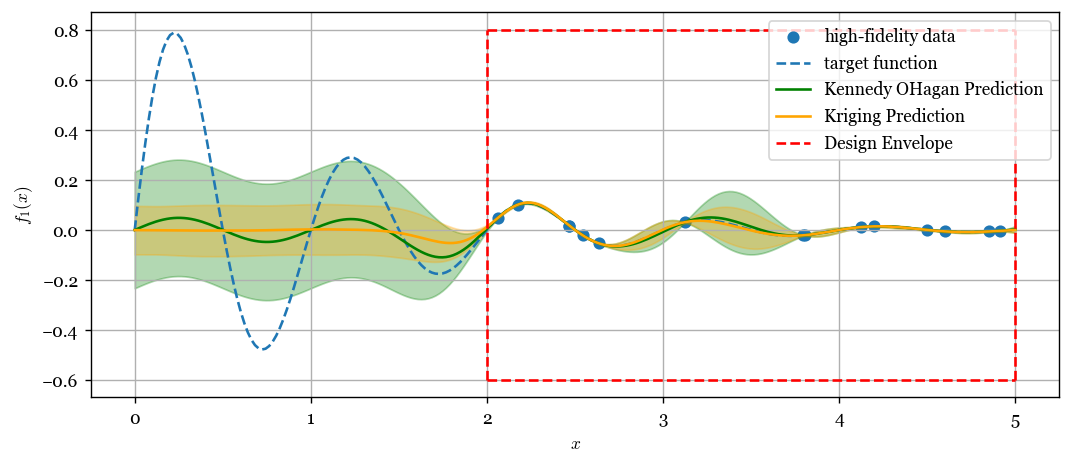

In [47]:
plt.figure(figsize=(10,4),dpi = 125)
plt.scatter(hf_data[:,0], hf_data[:,1], label = 'high-fidelity data')
plt.plot(Xtest.ravel(), funcs[0](Xtest), linestyle = 'dashed', label = 'target function')
plt.plot(Xtest.ravel(), mean.ravel(), color = 'green', label = 'Kennedy OHagan Prediction')
plt.fill_between(Xtest.ravel(), mean.ravel()-conf, mean.ravel()+conf, color = 'green', alpha = 0.3)

plt.plot(Xtest.ravel(), kr_mean.ravel(), color = 'orange', label = 'Kriging Prediction')
plt.fill_between(Xtest.ravel(), kr_mean.ravel() - kr_conf, kr_mean.ravel()+kr_conf, alpha = 0.3, color = 'orange')

plt.plot([cutoff, cutoff], [-0.6, 0.8], linestyle = 'dashed', color = 'red', label = 'Design Envelope')
plt.plot([cutoff, 5.0], [0.8, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([5.0, 5.0], [-0.6, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([cutoff, 5.0], [-0.6, -0.6], linestyle = 'dashed', color = 'red')
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.legend()